In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from metrics import get_best_threshold, compute_metrics, compute_auroc_and_build_roc
from data_preprocessing import preprocess_data
import warnings

In [12]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Data Load




In [7]:
raw_df = pd.read_csv('./data/weatherAUS.csv')
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [13]:
data, imputer, scaler, encoder, label_encoder, numeric_cols, categorical_cols, input_cols, target_col = preprocess_data(raw_df)

In [14]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']
X_test = data['test_X']
test_targets = data['test_y']

# Random Forest

In [15]:
# Random Forest params for Randomized Search
params_rf = {
    'max_depth': [5, 10, 15],
    'n_estimators': [200, 300, 500],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [4, 10, 20],
    'max_features': [0.3, 0.5, 0.7],  # Fraction of features to consider at each split
    'max_samples': [0.7, 0.8, 0.9],   # Fraction of samples to be used for each tree
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# Define RandomizedSearchCV
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    params_rf,
    cv=cv_strategy,
    scoring="f1",
    random_state=42,
    refit=True
)

In [18]:
# Fit on trainig data
rf_search.fit(X_train, train_targets)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': [0.3, 0.5, 0.7],
                                        'max_samples': [0.7, 0.8, 0.9],
                                        'min_samples_leaf': [4, 10, 20],
                                        'min_samples_split': [10, 20, 50],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, scoring='f1')

In [19]:
# Get the best model
rf = rf_search.best_estimator_

In [20]:
# Train the best model on the training data
rf.fit(X_train, train_targets)

RandomForestClassifier(max_depth=15, max_features=0.3, max_samples=0.8,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500, random_state=42)

In [22]:
rf_threshold = get_best_threshold(rf, X_val, val_targets)
print("Best threshold:", rf_threshold)

Best threshold: 0.35000000000000003


Precision score: 0.80
Recall score: 0.81
F1 score: 0.80


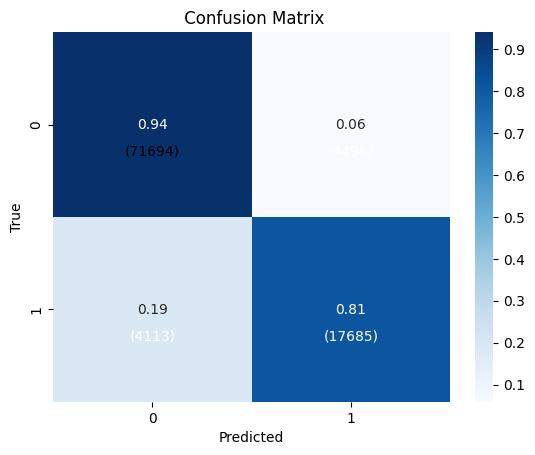

Precision score: 0.65
Recall score: 0.63
F1 score: 0.64


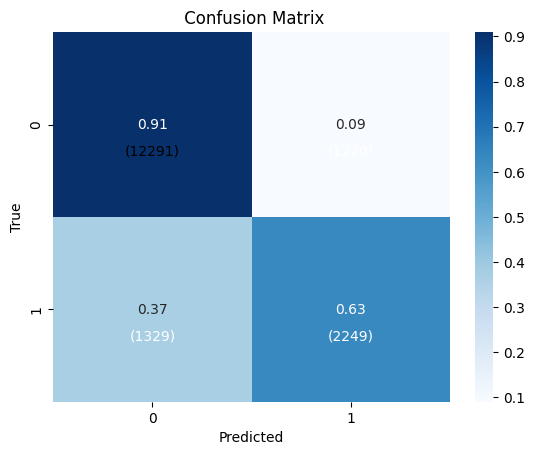

In [23]:
# Calculate the metrics
compute_metrics(rf, X_train, train_targets, threshold=rf_threshold)
compute_metrics(rf, X_val, val_targets, threshold=rf_threshold)

# XGB

In [24]:
# Function that specifies objective
def objective(model_class, param_space, params, **model_specific_params):
    # Convert hyperopt params to the correct types if necessary
    model_params = {key: int(value) if key in param_space['int_params'] else value for key, value in params.items()}

    # Initialize the model
    model = model_class(**model_params, **model_specific_params, random_state=42)

    # Fit the model
    try:
        model.fit(X_train, train_targets, eval_set=[(X_val, val_targets)], verbose=False)
    except TypeError:
        model.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

    # Compute F1
    preds = model.predict(X_val)
    f1 = f1_score(val_targets, preds)

    return {'loss': -f1, 'status': STATUS_OK}

# Wrapper function for hyperopt for XGB
def hyperopt_objective_XGB(params):
    return objective(XGBClassifier, param_space, params, enable_categorical=True)

# Function to find best hyperparameters
def optimize_hyperopt_params(objective, space, int_params, max_evals):
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=Trials())
    # Convert hyperparameter values to final types
    for key in int_params:
      best[key] = int(best[key])

    print("Best hyperparameters: ", best)

    return best

In [25]:
param_space = {
  'params': {
      'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
      'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
      'max_depth': hp.quniform('max_depth', 4, 10, 1),
      'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
      'subsample': hp.uniform('subsample', 0.5, 0.9),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
      'gamma': hp.uniform('gamma', 0.0, 0.5),
      'reg_alpha': hp.uniform('reg_alpha', 0, 5),
      'reg_lambda': hp.uniform('reg_lambda', 1, 10)
},
    'int_params': ['n_estimators', 'max_depth', 'min_child_weight']  # List of params that need to be converted to int
}

# Find best hyperparameters for XGB Classifier
best = optimize_hyperopt_params(hyperopt_objective_XGB, param_space['params'], param_space['int_params'], max_evals=50)

100%|██████████| 50/50 [19:03<00:00, 22.88s/trial, best loss: -0.6249193027759845]
Best hyperparameters:  {'colsample_bytree': 0.5551563057432762, 'gamma': 0.3316555843409854, 'learning_rate': 0.1417181952368065, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 500, 'reg_alpha': 1.343356637385777, 'reg_lambda': 3.834593759582266, 'subsample': 0.6191390576903858}


In [26]:
# Final model with the best parameters
xgb = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    random_state=42
)

xgb.fit(X_train, train_targets)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5551563057432762, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3316555843409854,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1417181952368065,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [27]:
xgb_threshold = get_best_threshold(xgb, X_val, val_targets)
print("Best threshold:", xgb_threshold)

Best threshold: 0.30000000000000004


Precision score: 0.75
Recall score: 0.87
F1 score: 0.81


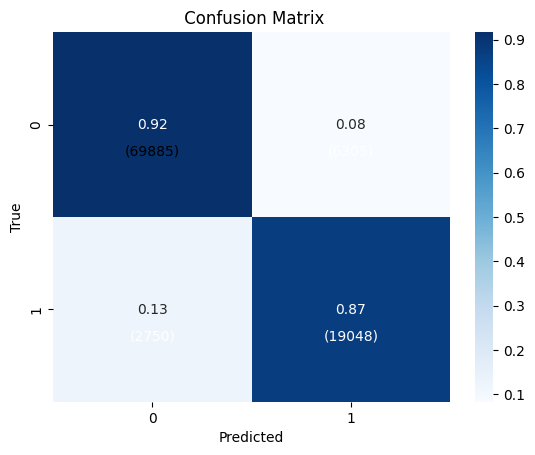

Precision score: 0.62
Recall score: 0.69
F1 score: 0.65


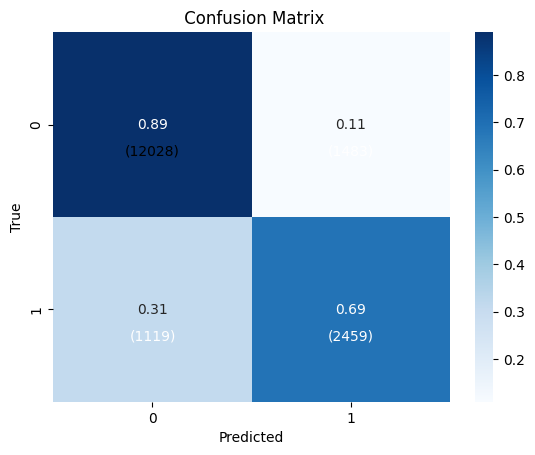

In [28]:
compute_metrics(xgb, X_train, train_targets, threshold=xgb_threshold)
compute_metrics(xgb, X_val, val_targets, threshold=xgb_threshold)

# LightGBM

In [ ]:
# Wrapper function for hyperopt for LGBM
def hyperopt_objective_lgbm(params):
    return objective(LGBMClassifier, param_space, params, enable_categorical=True)

param_space = {
    'params': {
      'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
      'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
      'max_depth': hp.quniform('max_depth', 4, 12, 1),
      'num_leaves': hp.quniform('num_leaves', 20, 100, 5),
      'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
      'subsample': hp.uniform('subsample', 0.5, 0.9),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
      'reg_alpha': hp.uniform('reg_alpha', 0.0, 5.0),
      'reg_lambda': hp.uniform('reg_lambda', 0.0, 10.0),
      'min_split_gain': hp.uniform('min_split_gain', 0.0, 0.5)
}
,
    'int_params': ['n_estimators', 'max_depth', 'num_leaves']  # List of params that need to be converted to int
}

# Find best hyperparameters for LGBM Classifier
best_lgbm = optimize_hyperopt_params(hyperopt_objective_lgbm, param_space['params'], param_space['int_params'], max_evals=50)

In [ ]:
# Final model with the best parameters
lgbm = LGBMClassifier(
    n_estimators=best_lgbm['n_estimators'],
    learning_rate=best_lgbm['learning_rate'],
    max_depth=best_lgbm['max_depth'],
    num_leaves=best_lgbm['num_leaves'],
    min_child_weight=best_lgbm['min_child_weight'],
    subsample=best_lgbm['subsample'],
    colsample_bytree=best_lgbm['colsample_bytree'],
    reg_alpha=best_lgbm['reg_alpha'],
    reg_lambda=best_lgbm['reg_lambda'],
    min_split_gain=best_lgbm['min_split_gain'],
    random_state=42
)

lgbm.fit(X_train, train_targets)

In [35]:
lgbm_threshold = get_best_threshold(lgbm, X_val, val_targets)
print("Best threshold:", lgbm_threshold)

Best threshold: 0.30000000000000004


Precision score: 0.68
Recall score: 0.80
F1 score: 0.74


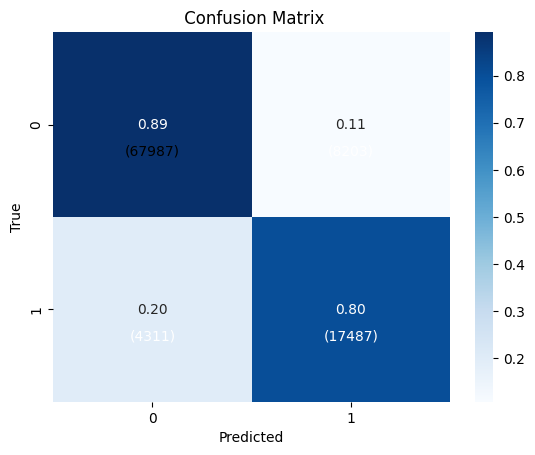

Precision score: 0.62
Recall score: 0.69
F1 score: 0.65


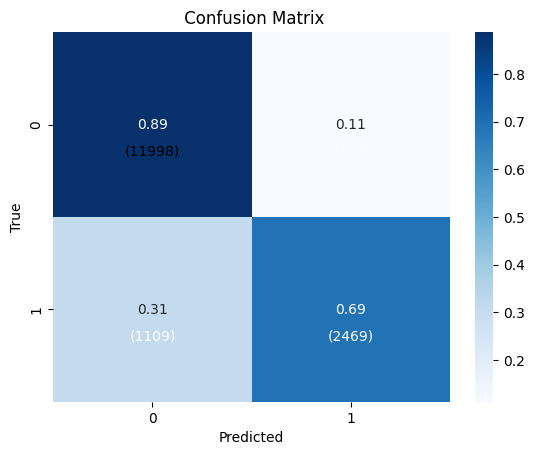

In [36]:
compute_metrics(lgbm, X_train, train_targets, threshold=lgbm_threshold)
compute_metrics(lgbm, X_val, val_targets, threshold=lgbm_threshold)

# Model comparison on test dataset

AUROC for Random Forest: 0.87


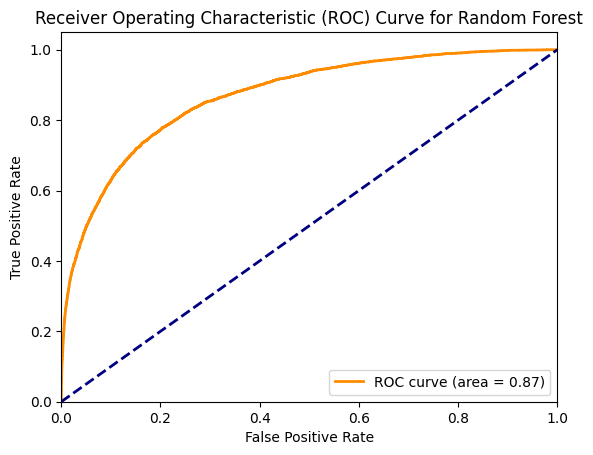

In [37]:
compute_auroc_and_build_roc(rf, X_test, test_targets, name='Random Forest')

AUROC for XGB: 0.88


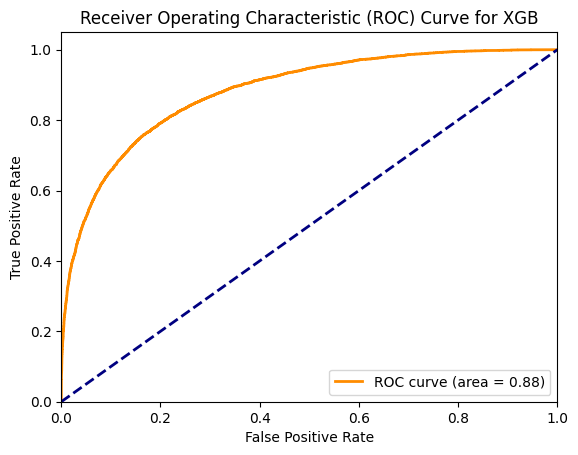

In [38]:
compute_auroc_and_build_roc(xgb, X_test, test_targets, name='XGB')

AUROC for LGBM: 0.88


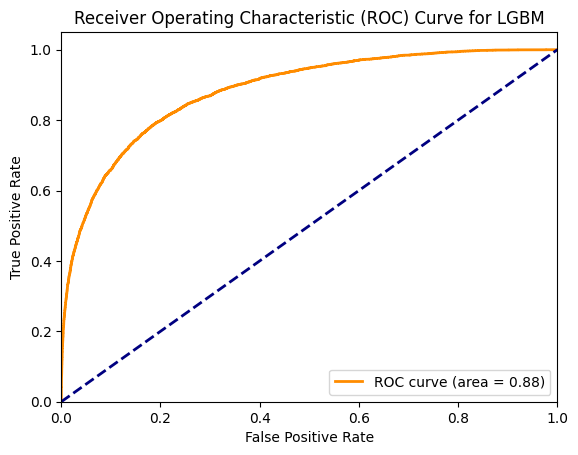

In [39]:
compute_auroc_and_build_roc(lgbm, X_test, test_targets, name='LGBM')

Precision score: 0.63
Recall score: 0.65
F1 score: 0.64


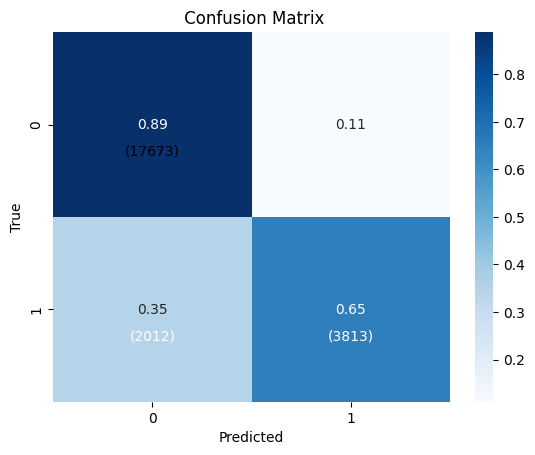

In [40]:
compute_metrics(rf, X_test, test_targets, threshold=rf_threshold)

Precision score: 0.61
Recall score: 0.72
F1 score: 0.66


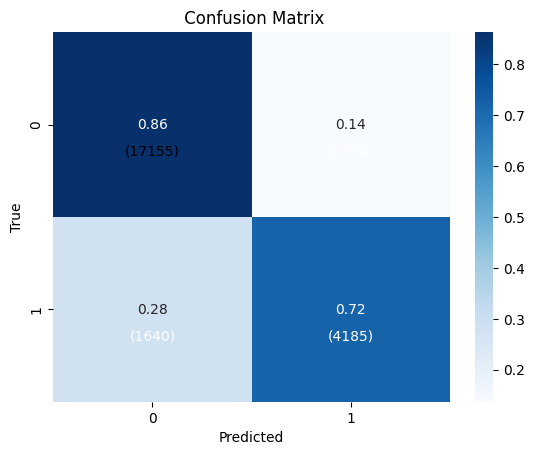

In [41]:
compute_metrics(xgb, X_test, test_targets, threshold=xgb_threshold)

Precision score: 0.61
Recall score: 0.73
F1 score: 0.66


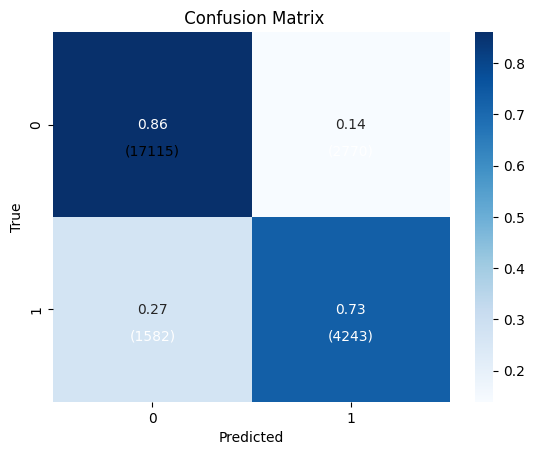

In [42]:
compute_metrics(lgbm, X_test, test_targets, threshold=lgbm_threshold)

# Saving the best model

In [ ]:
aussie_rain = {
    'model': lgbm,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols
}

In [ ]:
joblib.dump(aussie_rain, '/aussie_rain.joblib', compress=('zlib', 3))

['aussie_raint.joblib']